In [1]:
import pandas as pd

dfI=pd.read_csv("ScrapeClassI.csv")
dfT=pd.read_csv("ScrapeTerminated.csv")

#print(dfI.head())
print('dfI:', dfI.shape)
print('recall number unique rate:', dfI['recall_number'].nunique()/dfI.shape[0])
print('event id unique rate:', dfI['event_id'].nunique()/dfI.shape[0])
print('postal code missing rate:', dfI['postal_code'].isnull().sum()/dfI.shape[0])
print(dfI['country'].value_counts())
print(dfI['status'].value_counts())

print('\n')
print('dfT:', dfT.shape)
print('recall number unique rate:', dfT['recall_number'].nunique()/dfT.shape[0])
print('event id unique rate:', dfT['event_id'].nunique()/dfT.shape[0])
print('postal code missing rate:', dfT['postal_code'].isnull().sum()/dfT.shape[0])
print(dfT['country'].value_counts())
print(dfT['classification'].value_counts())

dfI: (6492, 19)
recall number unique rate: 0.9935304990757856
event id unique rate: 0.24491682070240295
postal code missing rate: 0.00616142945163
United States    6452
Canada             31
France              3
Italy               2
Taiwan              2
Guatemala           1
Australia           1
Name: country, dtype: int64
Terminated    3763
Ongoing       2457
Completed      272
Name: status, dtype: int64


dfT: (7935, 20)
recall number unique rate: 0.9984877126654065
event id unique rate: 0.23994959042218023
postal code missing rate: 0.00529300567108
United States    7892
Canada             32
Chile               5
France              4
Guatemala           1
Thailand            1
Name: country, dtype: int64
Class II     3859
Class I      3763
Class III     313
Name: classification, dtype: int64


### Clean Data

In [2]:
# Need a subset of ScarpeClassI with and "ongoing"
dfI = dfI[dfI.country == 'United States']
dfI = dfI[dfI.status == 'Ongoing']
print('dfI:', dfI.shape)

# Need a subset of ScrapeTerminated with "Class I"
dfT = dfT[dfT.country == 'United States']
dfT = dfT[dfT.classification == 'Class I']
print('dfT', dfT.shape)

# Combine two subsets, get a new set of "Class I" with both "terminated" and "ongoing"
df = pd.concat([dfI, dfT])
print('Combined df:', df.shape)

dfI: (2439, 19)
dfT (3741, 20)
Combined df: (6180, 20)


In [3]:
# recall init date < center classif date < report date
# we only keep "recall init date" and "termination date (if possible)"
df = df.drop('center_classification_date', axis=1)
df = df.drop('report_date', axis=1) 
df = df.drop('voluntary_mandated', axis=1)

# convert string to datetime
df['recall_initiation_date'] = pd.to_datetime(df['recall_initiation_date'], format="%Y%m%d")
df['termination_date'] = pd.to_datetime(df['termination_date'], format="%Y%m%d")
# calculate the duration
df['duration'] = df['termination_date'] - df['recall_initiation_date']

print(df.shape)
df.head()

(6180, 18)


,city,classification,code_info,country,distribution_pattern,event_id,initial_firm_notification,postal_code,product_description,product_type,reason_for_recall,recall_initiation_date,recall_number,recalling_firm,state,status,termination_date,duration
0,Silver Bay,Class I,wilderness family naturals coconut chia puddin...,United States,usa: nationwide ous: canada,73276,press release,55614-1211,lot numbers: 1000011556 1000011723 10000...,Food,wilderness family naturals organic coconut mil...,2016-02-12,F-0760-2016,wilderness family naturals llc,MN,Ongoing,NaT,NaT
5,Mamaroneck,Class I,refrigerated ready-to-eat sliced cold smoked p...,United States,ny nj ct il al mn mt,76952,press release,10543-2232,lots 82 through 96 (listed on back of packagin...,Food,the products have the potential to be contamin...,2017-04-07,F-2257-2017,the smokehouse of new york llc,NY,Ongoing,NaT,NaT
6,Camden,Class I,nor-tech dairy mozz/muenster/prov feather shr...,United States,domestic: michigan indiana illinois ohiopennsy...,75426,telephone,49232-9010,best used by: 12-05-2016,Food,kuster's inc is voluntarily recalling its shre...,2016-10-10,F-0439-2017,kuster's inc,MI,Ongoing,NaT,NaT
7,Edison,Class I,deer cumin powder packed for best foods inc ed...,United States,de ct ma pa nj ny & va,70929,press release,08817-6003,no codes,Food,cumin powder 7 oz and 14 oz may contain undecl...,2015-04-06,F-2303-2015,best foods nj inc,NJ,Ongoing,NaT,NaT
11,Austin,Class I,grassfields polkton corners cheese cut and wra...,United States,nationwide,74864,e-mail,78703-4648,plu codes that range from 0206151 to 0206159 ...,Food,possible contamination with shiga toxin-produc...,2016-08-03,F-2150-2016,whole foods market,TX,Ongoing,NaT,NaT


### Create New Features

In [4]:
# decrease the reasons for recall into 3 types
df['listeria'] = df['reason_for_recall'].str.contains("listeria").astype(int) 
df['salmonella'] = df['reason_for_recall'].str.contains("salmonella").astype(int) 
df['allergen/undeclared'] = df['reason_for_recall'].str.contains("allergen|undeclared").astype(int) 

# choose some food as features
df['salad/slaw'] = df['reason_for_recall'].str.contains("salad|slaw").astype(int) 
df['peanut'] = df['reason_for_recall'].str.contains("peanut").astype(int) 
df['butter'] = df['reason_for_recall'].str.contains("butter").astype(int) 
df['milk'] = df['reason_for_recall'].str.contains("milk").astype(int) 
df['ice-cream'] = df['reason_for_recall'].str.contains("ice cream").astype(int) 
df.shape

(6180, 26)

### Visualization and Analysis

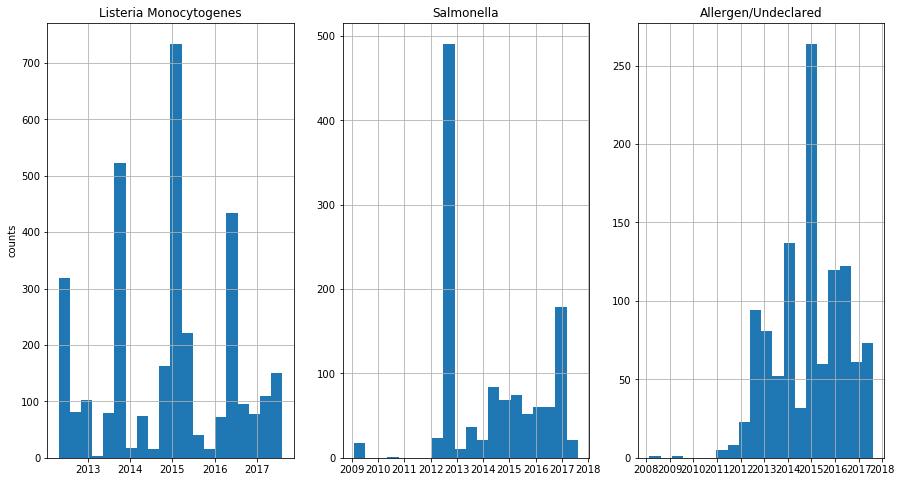

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()

fig.add_subplot(131)     
df.recall_initiation_date[df.listeria==1].hist(bins=20, figsize=(15,8),grid=True)
plt.title("Listeria Monocytogenes")
plt.ylabel('counts')

fig.add_subplot(132)
df.recall_initiation_date[df.salmonella==1].hist(bins=20)
plt.title("Salmonella")

fig.add_subplot(133)
df.recall_initiation_date[df['allergen/undeclared']==1].hist(bins=20)
plt.title("Allergen/Undeclared")

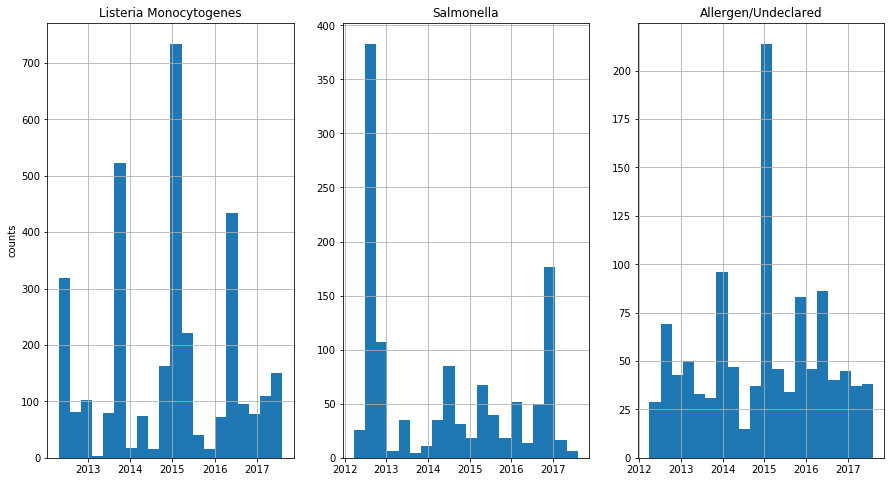

In [32]:
# drop records before 2012
df = df[df.recall_initiation_date > '2012-01-01']

# plot again
fig = plt.figure()

fig.add_subplot(131)     
df.recall_initiation_date[df.listeria==1].hist(bins=20, figsize=(15,8),grid=True)
plt.title("Listeria Monocytogenes")
plt.ylabel('counts')

fig.add_subplot(132)
df.recall_initiation_date[df.salmonella==1].hist(bins=20)
plt.title("Salmonella")

fig.add_subplot(133)
df.recall_initiation_date[df['allergen/undeclared']==1].hist(bins=20)
plt.title("Allergen/Undeclared")

Listeria monocytogenes is the most serious one of the three types, and it seems that an apparent time cycle exits. 
Salmonella is serious in 2012 and the end of 2016. Allergen or undeclared is serious in 2015.

In [72]:
from pandas.plotting import scatter_matrix
myData=pd.concat([df['listeria'], df['salmonella'],df['allergen/undeclared']], axis=1) 
print('Correlation Matrix:\n', myData.corr())

Correlation Matrix:
                      listeria  salmonella  allergen/undeclared
listeria             1.000000   -0.530056            -0.513032
salmonella          -0.530056    1.000000            -0.230030
allergen/undeclared -0.513032   -0.230030             1.000000


In [74]:
# drop records not included in the three types of reasons for recall
df = pd.concat([df[df.listeria==1], df[df.salmonella==1], df[df['allergen/undeclared']==1]])
print(df.shape)

# do again
myData=pd.concat([df['listeria'], df['salmonella'],df['allergen/undeclared']], axis=1) 
print('Correlation Matrix:\n', myData.corr())

(5628, 26)
Correlation Matrix:
                      listeria  salmonella  allergen/undeclared
listeria             1.000000   -0.619792            -0.599463
salmonella          -0.619792    1.000000            -0.256586
allergen/undeclared -0.599463   -0.256586             1.000000


* The types of "listeria" and "salmonella" are kind of negative related (correlation value: -0.62), which means that if one product has the problem "listeria", then it has little chance to also have "salmonella", and vice versa. 

* The same holds to "listeria" and "allergen/undeclared" (correlation value: -0.60).

* The type of "allergen/undeclared" is almost unrelated to "salmonella" (correlation value: -0.25), which means that if one product has the problem "allergen/undeclared", we cannot not tell whether it also has "salmonella".

In [76]:
myfile="CleanedData_Features.csv"
df.to_csv(myfile,sep=',')

### Association Rule

In [112]:
df_l, df_s, df_a = df[df.listeria==1], df[df.salmonella==1], df[df['allergen/undeclared']==1]
df_sd, df_pnt, df_bt, df_mk, df_ice = df[df['salad/slaw']==1], df[df.peanut==1], df[df.butter==1], df[df.milk==1], df[df['ice-cream']==1]

print("support({'listeria'}) =", df_l.shape[0])
print("support({'salmonella'}) =", df_s.shape[0])
print("support({'allergen/undeclared'}) =", df_a.shape[0])
print('\n')

print("support({'salad/slaw'}) =", df_sd.shape[0])
print("support({'peanut'}) =", df_pnt.shape[0])
print("support({'butter'}) =", df_bt.shape[0])
print("support({'milk'}) =", df_mk.shape[0])
print("support({'ice-cream'}) =", df_ice.shape[0])

support({'listeria'}) = 3329
support({'salmonella'}) = 1180
support({'allergen/undeclared'}) = 1119


support({'salad/slaw'}) = 661
support({'peanut'}) = 625
support({'butter'}) = 443
support({'milk'}) = 574
support({'ice-cream'}) = 306


In [122]:
print("support({'listeria', 'salad/slaw'}) =", df_l[df_l['salad/slaw']==1].shape[0])
print("support({'listeria', 'peanut'}) =", df_l[df_l.peanut==1].shape[0])
print("support({'listeria', 'butter'}) =", df_l[df_l.butter==1].shape[0])
print("support({'listeria', 'milk'}) =", df_l[df_l.milk==1].shape[0])
print("support({'listeria', 'ice-cream'}) =", df_l[df_l['ice-cream']==1].shape[0])
print('\n')

print("support({'salmonella', 'salad/slaw'}) =", df_s[df_s['salad/slaw']==1].shape[0])
print("support({'salmonella', 'peanut'}) =", df_s[df_s.peanut==1].shape[0])
print("support({'salmonella', 'butter'}) =", df_s[df_s.butter==1].shape[0])
print("support({'salmonella', 'milk'}) =", df_s[df_s.milk==1].shape[0])
print("support({'salmonella', 'ice-cream'}) =", df_s[df_s['ice-cream']==1].shape[0])
print('\n')

print("support({'allergen/undeclared', 'salad/slaw'}) =", df_a[df_a['salad/slaw']==1].shape[0])
print("support({'allergen/undeclared', 'peanut'}) =", df_a[df_a.peanut==1].shape[0])
print("support({'allergen/undeclared', 'butter'}) =", df_a[df_a.butter==1].shape[0])
print("support({'allergen/undeclared', 'milk'}) =", df_a[df_a.milk==1].shape[0])
print("support({'allergen/undeclared', 'ice-cream'}) =", df_a[df_a['ice-cream']==1].shape[0])
print('\n')

print("support({'peanut', 'butter'}) =", df_pnt[df_pnt.butter==1].shape[0])

support({'listeria', 'salad/slaw'}) = 634
support({'listeria', 'peanut'}) = 38
support({'listeria', 'butter'}) = 72
support({'listeria', 'milk'}) = 2
support({'listeria', 'ice-cream'}) = 287


support({'salmonella', 'salad/slaw'}) = 5
support({'salmonella', 'peanut'}) = 337
support({'salmonella', 'butter'}) = 328
support({'salmonella', 'milk'}) = 46
support({'salmonella', 'ice-cream'}) = 3


support({'allergen/undeclared', 'salad/slaw'}) = 22
support({'allergen/undeclared', 'peanut'}) = 250
support({'allergen/undeclared', 'butter'}) = 43
support({'allergen/undeclared', 'milk'}) = 526
support({'allergen/undeclared', 'ice-cream'}) = 16


support({'peanut', 'butter'}) = 373


##### Set the support level = 100. Calculate the confidence values.

In [124]:
print("conf({'listeria'}->{'salad/slaw'}) = %.2f" % (df_l[df_l['salad/slaw']==1].shape[0]/df_l.shape[0]))
print("conf({'listeria'}->{'ice-cream'}) = %.2f" % (df_l[df_l['ice-cream']==1].shape[0]/df_l.shape[0]))
print('\n')

print("conf({'salmonella'}->{'peanut'}) = %.2f" % (df_s[df_s.peanut==1].shape[0]/df_s.shape[0]))
print("conf({'salmonella'}->{'butter'}) = %.2f" % (df_s[df_s.butter==1].shape[0]/df_s.shape[0]))
print('\n')

print("conf({'allergen/undeclared'}->{'peanut'}) = %.2f" % (df_a[df_a.peanut==1].shape[0]/df_a.shape[0]))
print("conf({'allergen/undeclared'}->{'milk'}) = %.2f" % (df_a[df_a.milk==1].shape[0]/df_a.shape[0]))
print('\n')

print("conf({'peanut'}->{'butter'}) = %.2f" % (df_pnt[df_pnt.butter==1].shape[0]/df_pnt.shape[0]))
print("conf({'butter'}->{'peanut'}) = %.2f" % (df_pnt[df_pnt.butter==1].shape[0]/df_bt.shape[0]))

conf({'listeria'}->{'salad/slaw'}) = 0.19
conf({'listeria'}->{'ice-cream'}) = 0.09


conf({'salmonella'}->{'peanut'}) = 0.29
conf({'salmonella'}->{'butter'}) = 0.28


conf({'allergen/undeclared'}->{'peanut'}) = 0.22
conf({'allergen/undeclared'}->{'milk'}) = 0.47


conf({'peanut'}->{'butter'}) = 0.60
conf({'butter'}->{'peanut'}) = 0.84


* For the type of "listeria", 19% of the products contain salad or slaw, and 9% of the products contain ice-cream.

* For the type of "salmonella", 29% of the products contain peanut, and 28% of the products contain butter.

* For the type of "allergen/undeclared", 22% of the products contain peanut, and 47% of the products contain milk.
* For all the products containing peanut, 60% of them also contain butter; for all the products containing butter, 84% of them contain peanut. This reminds me that peanut butter is quite popular in the U.S.

### Anything about Duration (from the start date to the termination date)

In [ ]:

#The distributions of listeria's duration and salmonella's duration (<= 13 months) are the same.
#Method: T test
def Hypothesis1():   
    print("\n\n Hypothesis 1:")
    df.month = df["duration_groups(month)"]
    
    # Hypothesis 1: the distributions of listeria's duration and salmonella's duration (<= 13 months) are the same. 
    
    # get the duration (month) of listeria and salmonella
    month_listeria = df.month[df.listeria==1]
    month_salmonella = df.month[df.salmonella==1]
    # look at the histgrams
    fig = plt.figure()
    fig.add_subplot(111)  
    month_listeria.hist(bins=30)
    month_salmonella.hist(bins=30)
    plt.title("Duration Histograms of listeria (blue) and salmonella (green)")
    plt.show()
    # According to the histgrams, we choose the part month <= 13
    # to make the data like normal distributed (although they are still not!)
    month_listeria = month_listeria[df.month <= 13]
    month_salmonella = month_salmonella[df.month <= 13]
    # look at the new histgrams again
    fig = plt.figure()
    fig.add_subplot(111)  
    month_listeria.hist(bins=30)
    month_salmonella.hist(bins=30)
    plt.title("New Duration Histograms of listeria (blue) and salmonella (green)")
    plt.show()
    
    print("mean of listeria: %.2f" % month_listeria.mean())
    print("var of listeria: %.2f" % month_listeria.var())
    print("mean of salmonella: %.2f" % month_salmonella.mean())
    print("var of salmonella: %.2f" % month_salmonella.var())
    print("T test Results: ")
    print(stats.ttest_ind(month_listeria,month_salmonella,equal_var = False))
Hypothesis1()


#The variables of duration (days) and duration (months) have linear relationship.
#Method: linear regression, naive bayes, decision trees, knn, random forests, svm.
def Hypothesis2():
    print("\n\n Hypothesis 2:")
    df = pd.read_csv("TerminatedAnalysis.csv",encoding='latin1')
    #print(df.columns)
    # Rename
    df.month = df["duration_groups(month)"]
    x = pd.concat([df.term_init_duration, df.month],
                  axis=1, keys=['duration','month'])    
    X = x.iloc[:,0:1]
    y = x.iloc[:,1]
    # make the validation set 20% of the entire
    test_size = 0.20
    seed = 7
    # set of labeled data (X_test, Y_test)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    print("Linear Regression: ")
    print('Coefficients: ', regr.coef_)
    print("Mean squared error: %.2f" % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    
    # Plot Linear Regression of duration (days) and duration (month)
    fig = plt.figure()
    fig.add_subplot(111)  
    plt.scatter(X_test.iloc[:,0], y_test,  color='black')
    plt.plot(X_test.iloc[:,0], regr.predict(X_test), color='blue', linewidth=3)
    plt.xlabel('days')
    plt.ylabel('months')
    plt.title("Linear Regression of duration (days) and duration (month)")
    plt.show()
    
    num_folds = 10
    num_instances = len(X_train)
    scoring = 'accuracy'
    
    # Use different algorithms to build models
    # Add each algorithm and its name to the model array
    models = []
    models.append(('NB', GaussianNB()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('SVM', SVC()))
    #models.append(('Linear Regression', linear_model.LinearRegression()))
    
    # Evaluate each model, add results to a results array,
    # Print the accuracy results (remember these are averages and std
    results = []
    names = []
    for name, model in models:
        	kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        	cv_results = cross_validation.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        	results.append(cv_results)
        	names.append(name)
        	msg = "%s: Mean: %f Std: %f " % (name, cv_results.mean(), cv_results.std())
        	print(msg)  
    
    print("Accuracy Score on validation dataset:")    
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    predictions = nb.predict(X_test)
    print("Naive Bayes: %.2f" % accuracy_score(y_test, predictions))
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_test)
    print("Decision Tree: %.2f" % accuracy_score(y_test, predictions))
    
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    print("KNN: %.2f" % accuracy_score(y_test, predictions))
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    print("Random Forest: %.2f" % accuracy_score(y_test, predictions))
    
    svm = SVC()
    svm.fit(X_train, y_train)
    predictions = svm.predict(X_test)
    print("SVM: %.2f" % accuracy_score(y_test, predictions))
    
Hypothesis2()



#Given that one recalled food is salad/slaw, according to if it has the problem with listeria, we can predict its recall duration. 
#Method: naive bayes, decision trees, knn, random forests, svm.
def Hypothesis3():
    print("\n\n Hypothesis 3:")
    df = pd.read_csv("TerminatedAnalysis.csv",encoding='latin1')
    #print(df.columns)
    # Rename
    df.month = df["duration_groups(month)"]
    df.salad = df["salad/slaw"]
    x = pd.concat([df.listeria[df.salad==1],df.month[df.salad==1]],
                  axis=1, keys=['listeria','month'])  
    X = x.iloc[:,0:1]
    y = x.iloc[:,1]    
    # make the validation set 20% of the entire
    test_size = 0.20
    seed = 7
    # set of labeled data (X_validate, Y_validate)
    X_train, X_validate, y_train, y_validate = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)
    # Setup 10-fold cross validation to estimate the accuracy of different models
    num_folds = 10
    num_instances = len(X_train)
    scoring = 'accuracy'
    
    # Use different algorithms to build models
    # Add each algorithm and its name to the model array
    models = []
    models.append(('NB', GaussianNB()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('SVM', SVC()))
    #models.append(('Linear Regression', linear_model.LinearRegression()))
    
    # Evaluate each model, add results to a results array,
    # Print the accuracy results (remember these are averages and std
    results = []
    names = []
    for name, model in models:
        	kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        	cv_results = cross_validation.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        	results.append(cv_results)
        	names.append(name)
        	msg = "%s: Mean: %f Std: %f " % (name, cv_results.mean(), cv_results.std())
        	print(msg)
    
    print("Accuracy Score on validation dataset:")
    # Make predictions on validation dataset
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    predictions = nb.predict(X_validate)
    print("Naive Bayes: %.2f" % accuracy_score(y_validate, predictions))
        
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_validate)
    print("Decision Tree: %.2f" % accuracy_score(y_validate, predictions))
            
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_validate)
    print("KNN: %.2f" % accuracy_score(y_validate, predictions))
   
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_validate)
    print("Random Forest: %.2f" % accuracy_score(y_validate, predictions))
         
    svm = SVC()
    svm.fit(X_train, y_train)
    predictions = svm.predict(X_validate)
    print("SVM: %.2f" % accuracy_score(y_validate, predictions))
       
Hypothesis3()